In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import matplotlib.pyplot as plt
import matplotlib

from pylab import plot,show, hist, rcParams 
rcParams['figure.figsize'] = 10, 5

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cross_validation import train_test_split

%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


#plt.rc("font", size=14)

# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Задания:

- Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
- Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
- Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

Дополнительно

- Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
- Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

## Решение

### Часть I: Первичный анализ данных

In [2]:
data = pd.read_csv('data/Kobe.csv')
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


##### Посмотрим наши данныые

In [3]:
data.shape

(30697, 25)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

пропущенные значения есть только у признака `shot_made_flag`, это как раз наш таргет

In [5]:
#data['action_type'].unique()

In [6]:
#data['combined_shot_type'].unique()

In [7]:
#data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
#data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
#data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

Посмотрим на наш таргет `shot_made_flag`

In [8]:
data['shot_made_flag'].count()

25697

Посмотрим на распределение значений нашего таргета

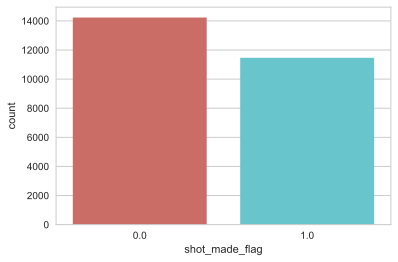

In [9]:
sns.countplot(x = 'shot_made_flag', data=data, palette='hls')
plt.show()

In [10]:
count_no_sub = len(data[data['shot_made_flag']==0])
count_sub = len(data[data['shot_made_flag']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("Процент нереализованных бросков", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("Процент реализованных бросков", pct_of_sub*100)

Процент нереализованных бросков 55.38389695295171
Процент реализованных бросков 44.61610304704829


Рспределение достаточно сбалансированное, это очень неплохо

In [11]:
#посмотрим средние по нашему таргету к осталным признакам
data.groupby('shot_made_flag').mean()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,team_id,shot_id
shot_made_flag,,,,,,,,,,,,,
0.0,254.353710,2.475229e+07,33.941328,7.232153,102.972456,-118.262568,4.798974,2.554033,0.146641,27.827080,15.127600,1.610613e+09,15431.673201
1.0,243.135717,2.472719e+07,33.967585,7.044483,76.714871,-118.262756,4.995813,2.479546,0.145748,28.912952,11.383428,1.610613e+09,15199.680157


In [12]:
#посмотрим на распределение кол-ва бросков по расстоянию 
data.groupby('shot_zone_range')['shot_made_flag'].count()

shot_zone_range
16-24 ft.          6907
24+ ft.            5281
8-16 ft.           5580
Back Court Shot      72
Less Than 8 ft.    7857
Name: shot_made_flag, dtype: int64

In [13]:
#посмотрим на распределение реализации бросков по расстоянию 
data.groupby('shot_made_flag')['shot_zone_range'].value_counts()

shot_made_flag  shot_zone_range
0.0             16-24 ft.          4132
                24+ ft.            3525
                Less Than 8 ft.    3354
                8-16 ft.           3150
                Back Court Shot      71
1.0             Less Than 8 ft.    4503
                16-24 ft.          2775
                8-16 ft.           2430
                24+ ft.            1756
                Back Court Shot       1
Name: shot_zone_range, dtype: int64

In [14]:
#посмотрим какие броски выполнял Коби с какого расстояния и какая была реализация таргета
data.groupby(['shot_made_flag','shot_zone_range'])['combined_shot_type'].value_counts()

shot_made_flag  shot_zone_range  combined_shot_type
0.0             16-24 ft.        Jump Shot             4128
                                 Bank Shot                2
                                 Hook Shot                1
                                 Layup                    1
                24+ ft.          Jump Shot             3524
                                 Bank Shot                1
                8-16 ft.         Jump Shot             3116
                                 Bank Shot               16
                                 Hook Shot               14
                                 Layup                    4
                Back Court Shot  Jump Shot               71
                Less Than 8 ft.  Layup                 1966
                                 Jump Shot             1163
                                 Tip Shot                99
                                 Dunk                    76
                                 Hook Shot      

Text(0,0.5,'Кол-во бросков')

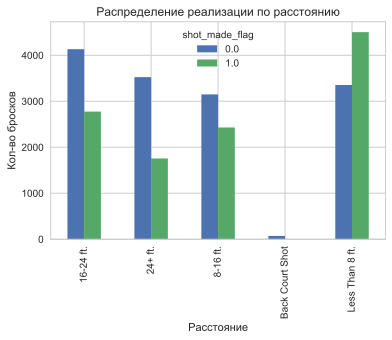

In [15]:
%matplotlib inline
pd.crosstab(data.shot_zone_range,data.shot_made_flag).plot(kind='bar')
plt.title('Распределение реализации по расстоянию')
plt.xlabel('Расстояние')
plt.ylabel('Кол-во бросков')

Очень интересная картина, только фактически из под кольца `Less Than 8 ft` у Коби залетает больше мячей чем промахивается, интересное наблюдение, при генерации фич надо будет обратить на это внимание, возможно это отличный предиктор

Text(0,0.5,'Кол-во бросков')

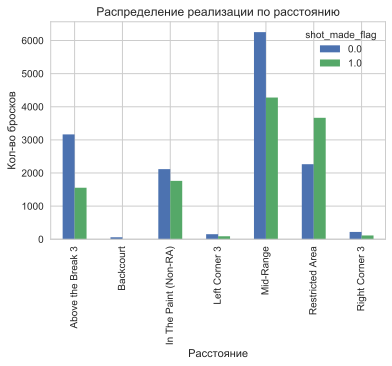

In [16]:
pd.crosstab(data.shot_zone_basic,data.shot_made_flag).plot(kind='bar')
plt.title('Распределение реализации по расстоянию')
plt.xlabel('Расстояние')
plt.ylabel('Кол-во бросков')

`shot_zone_basic` фактически уже готовые фичи

Text(0,0.5,'Кол-во бросков')

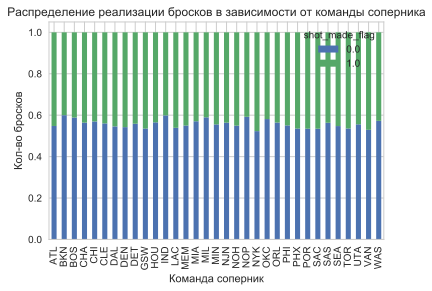

In [17]:
table=pd.crosstab(data.opponent,data.shot_made_flag)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Распределение реализации бросков в зависимости от команды соперника')
plt.xlabel('Команда соперник')
plt.ylabel('Кол-во бросков')

Распределение нашего таргета не сильно зависит от команды соперника, это очень хорошо видно из нашего графика, следовательно можно будет смело пренебречь признаком `opponent` как предиктором

Text(0,0.5,'Кол-во бросков')

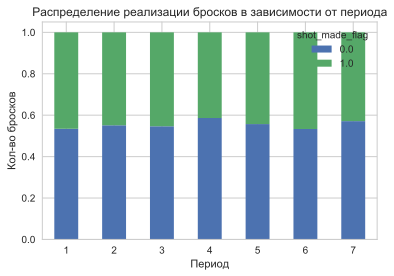

In [18]:
table=pd.crosstab(data.period,data.shot_made_flag)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, rot=360)
plt.title('Распределение реализации бросков в зависимости от периода')
plt.xlabel('Период')
plt.ylabel('Кол-во бросков')

Распределение нашего таргета не сильно зависит от периода, это очень хорошо видно из нашего графика, следовательно можно будет смело пренебречь признаком `period` как предиктором

Text(0,0.5,'Кол-во бросков')

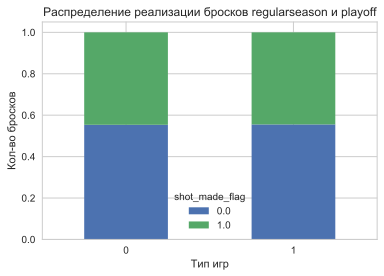

In [19]:
table=pd.crosstab(data.playoffs,data.shot_made_flag)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, rot=360)
plt.title('Распределение реализации бросков regularseason и playoff')
plt.xlabel('Тип игр')
plt.ylabel('Кол-во бросков')

Распределение нашего таргета не сильно зависит от статуса игры (регулярный сезон или плайофф), это очень хорошо видно из нашего графика, следовательно можно будет смело пренебречь признаком `playoffs` как предиктором

Text(0,0.5,'Кол-во бросков')

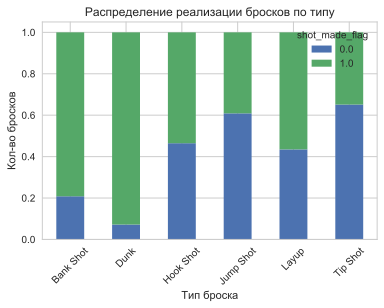

In [20]:
table=pd.crosstab(data.combined_shot_type,data.shot_made_flag)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, rot=45)
plt.title('Распределение реализации бросков по типу')
plt.xlabel('Тип броска')
plt.ylabel('Кол-во бросков')

круто!! это похоже на предиктор, будем дальше думать какие можно фичи строить опираясь на данное распределение

Text(0,0.5,'Кол-во бросков')

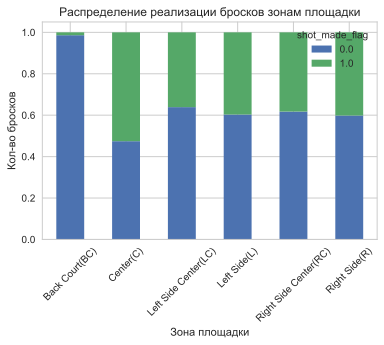

In [21]:
table=pd.crosstab(data.shot_zone_area,data.shot_made_flag)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, rot=45)
plt.title('Распределение реализации бросков зонам площадки')
plt.xlabel('Зона площадки')
plt.ylabel('Кол-во бросков')

In [22]:
data.groupby('shot_zone_area')['shot_made_flag'].value_counts()

shot_zone_area         shot_made_flag
Back Court(BC)         0.0                 71
                       1.0                  1
Center(C)              1.0               5933
                       0.0               5356
Left Side Center(LC)   0.0               2149
                       1.0               1215
Left Side(L)           0.0               1889
                       1.0               1243
Right Side Center(RC)  0.0               2458
                       1.0               1523
Right Side(R)          0.0               2309
                       1.0               1550
Name: shot_made_flag, dtype: int64

Думаю не очень это нам поможет, но учтем что такие данные тоже есть

Text(0,0.5,'Кол-во бросков')

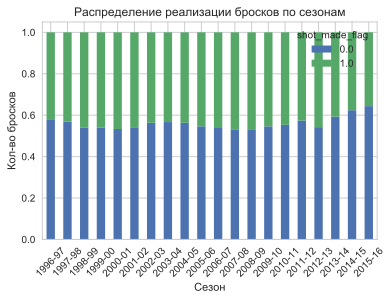

In [23]:
table=pd.crosstab(data.season,data.shot_made_flag)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, rot=45)
plt.title('Распределение реализации бросков по сезонам')
plt.xlabel('Сезон')
plt.ylabel('Кол-во бросков')

Распределение нашего таргета не сильно зависит от сезонов (Коби просто машина, мега стабильный игрок), это очень хорошо видно из нашего графика, следовательно можно будет смело пренебречь признаком `season` как предиктором

Text(0,0.5,'Тип бросков')

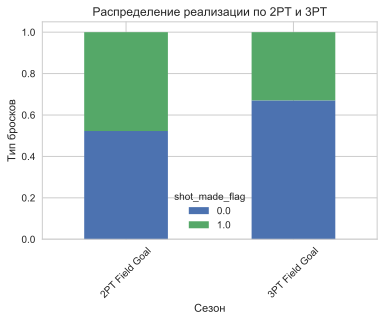

In [24]:
table=pd.crosstab(data.shot_type,data.shot_made_flag)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, rot=45)
plt.title('Распределение реализации по 2PT и 3PT')
plt.xlabel('Сезон')
plt.ylabel('Тип бросков')

Думаю тоже можно будет использовать как предиктор

### Выводы:

из всех признаков для дальнейшего анализа нам будут интересны следующие:
- `shot_zone_range`
- `shot_zone_basic`
- `combined_shot_type`
- `shot_zone_area`

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

### Часть II Подготовка фичей для обучения модели

В этой часте мы подготовим фичи для обучения модели - нагенерируем признаков, обработаем пропущенные значения, проверим наличие возможных выбросов и обработаем категориальные признаки.

In [26]:
#выполним преобразование категориальных в количественые признаки, будем использовать метод ine hot encoding
cat_vars=['shot_zone_range','shot_zone_basic','combined_shot_type','shot_zone_area',]
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
cat_vars=['shot_zone_range','shot_zone_basic','combined_shot_type','shot_zone_area',]
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [27]:
#data_final это наш подготовленный дата сет
data_final=data[to_keep]
data_final.columns.values

array(['action_type', 'game_event_id', 'game_id', 'lat', 'loc_x', 'loc_y',
       'lon', 'minutes_remaining', 'period', 'playoffs', 'season',
       'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'team_id', 'team_name', 'game_date', 'matchup',
       'opponent', 'shot_id', 'shot_zone_range_16-24 ft.',
       'shot_zone_range_24+ ft.', 'shot_zone_range_8-16 ft.',
       'shot_zone_range_Back Court Shot',
       'shot_zone_range_Less Than 8 ft.',
       'shot_zone_basic_Above the Break 3', 'shot_zone_basic_Backcourt',
       'shot_zone_basic_In The Paint (Non-RA)',
       'shot_zone_basic_Left Corner 3', 'shot_zone_basic_Mid-Range',
       'shot_zone_basic_Restricted Area',
       'shot_zone_basic_Right Corner 3', 'combined_shot_type_Bank Shot',
       'combined_shot_type_Dunk', 'combined_shot_type_Hook Shot',
       'combined_shot_type_Jump Shot', 'combined_shot_type_Layup',
       'combined_shot_type_Tip Shot', 'shot_zone_area_Back Court(BC)',
       'shot_

In [28]:
#уберем все пропуски (не будим работаь с пропущенными данными)
data_final =  data_final[pd.notnull(data_final['shot_made_flag'])]

In [29]:
data_final = data_final.drop(
                    labels=['opponent', 'matchup', 'game_date', 'team_name', 'shot_type', 'season', 'action_type'],
                    axis=1
                    )

In [38]:
#немного сбалансируем наши классы выполним оверсемплинг для этого используем алгоритм SMOTE
X = data_final.loc[:, data_final.columns != 'shot_made_flag']
y = data_final.loc[:, data_final.columns == 'shot_made_flag']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['shot_made_flag'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Количество переменных с таргетом = 0 равна -",len(os_data_y[os_data_y['shot_made_flag']==0]))
print("Количество переменных с таргетом = 1 равна -",len(os_data_y[os_data_y['shot_made_flag']==1]))
print("Доля нереализованных бросков",len(os_data_y[os_data_y['shot_made_flag']==0])/len(os_data_X))
print("Доля реализованных бросков",len(os_data_y[os_data_y['shot_made_flag']==1])/len(os_data_X))

length of oversampled data is  19856
Количество переменных с таргетом = 0 равна - 9928
Количество переменных с таргетом = 1 равна - 9928
Доля нереализованных бросков 0.5
Доля реализованных бросков 0.5


In [40]:
#X_train.columns.values

In [41]:
#выберем наиболее значимые фичи для реализации используем алгоритм RFE
data_final_vars=data_final.columns.values.tolist()
y=['shot_made_flag']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False False
 False  True  True  True  True  True False  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True False  True
 False]
[15 17  4 13 14  5 11  3 10 12  7 18 16  1  1  1  1  1  2  1  1  1  1  1
  8  1  1  1  1  1  1  1  1  1  9  1  6]


In [42]:
#отлично теперь у нас есть нужные нам фичи
cols= ['shot_id', 'shot_zone_range_16-24 ft.', 'shot_zone_range_24+ ft.',
       'shot_zone_range_8-16 ft.', 'shot_zone_range_Back Court Shot',
      'shot_zone_basic_Above the Break 3', 'shot_zone_basic_Backcourt',
       'shot_zone_basic_In The Paint (Non-RA)',
       'shot_zone_basic_Left Corner 3', 'shot_zone_basic_Mid-Range',
      'shot_zone_basic_Right Corner 3', 'combined_shot_type_Bank Shot',
       'combined_shot_type_Dunk', 'combined_shot_type_Hook Shot',
       'combined_shot_type_Jump Shot', 'combined_shot_type_Layup',
       'combined_shot_type_Tip Shot', 'shot_zone_area_Back Court(BC)',
       'shot_zone_area_Center(C)','shot_zone_area_Right Side Center(RC)']

In [43]:
X=os_data_X[cols]
y=os_data_y['shot_made_flag']

In [44]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.653314
         Iterations: 35
                                           Results: Logit
Model:                          Logit                        No. Iterations:               35.0000   
Dependent Variable:             shot_made_flag               Pseudo R-squared:             0.057     
Date:                           2018-11-06 10:38             AIC:                          25980.4233
No. Observations:               19856                        BIC:                          26122.5560
Df Model:                       17                           Log-Likelihood:               -12972.   
Df Residuals:                   19838                        LL-Null:                      -13763.   
Converged:                      0.0000                       Scale:                        1.0000    
-----------------------------------------------------------------------------------------------------
                                       Coef.     Std.Err.   

In [45]:
cols=['shot_zone_range_16-24 ft.', 'shot_zone_range_8-16 ft.', 
      'shot_zone_basic_Mid-Range', 'combined_shot_type_Bank Shot',
     'combined_shot_type_Dunk', 'combined_shot_type_Layup', 'combined_shot_type_Tip Shot',
      'shot_zone_area_Right Side Center(RC)',
     ]

In [46]:
X=os_data_X[cols]
y=os_data_y['shot_made_flag']

In [47]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.660456
         Iterations 7
                                   Results: Logit
Model:                     Logit                  No. Iterations:         7.0000    
Dependent Variable:        shot_made_flag         Pseudo R-squared:       0.047     
Date:                      2018-11-06 10:38       AIC:                    26244.0307
No. Observations:          19856                  BIC:                    26307.2008
Df Model:                  7                      Log-Likelihood:         -13114.   
Df Residuals:              19848                  LL-Null:                -13763.   
Converged:                 1.0000                 Scale:                  1.0000    
------------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [49]:
y_pred = logreg.predict(X_test)
print('Точность предсказания: {:.2f}'.format(logreg.score(X_test, y_test)))

Точность предсказания: 0.60


In [50]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[2360  645]
 [1762 1190]]


In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.57      0.79      0.66      3005
        1.0       0.65      0.40      0.50      2952

avg / total       0.61      0.60      0.58      5957



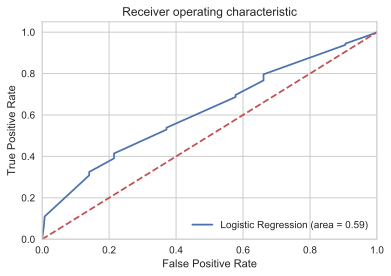

In [52]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()